In [9]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50  import preprocess_input


In [10]:
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range

In [21]:
datagenerator = ImageDataGenerator()

In [22]:
datagenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.80,1.20],
    fill_mode='nearest',
    color_mode = 'grayscale'
)

TypeError: __init__() got an unexpected keyword argument 'color_mode'

In [13]:
# load and iterate training dataset
train_data = datagenerator.flow_from_directory('../train/', 
    class_mode='binary',
    target_size=(224, 224), 
    batch_size=64, 
    shuffle=False)

# load and iterate validation dataset
val_data = datagenerator.flow_from_directory('../valid/', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1, 
    shuffle=False)

# load and iterate test dataset
test_data = datagenerator.flow_from_directory('../test/', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1, 
    shuffle=False)

Found 2600 images belonging to 2 classes.
Found 870 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 224 pixels width and 224 pixels height, one single color channel.
The maximum pixel value is 151.0610 and the minimum is -123.6800
The mean value of the pixels is 0.8581 and the standard deviation is 119.5804


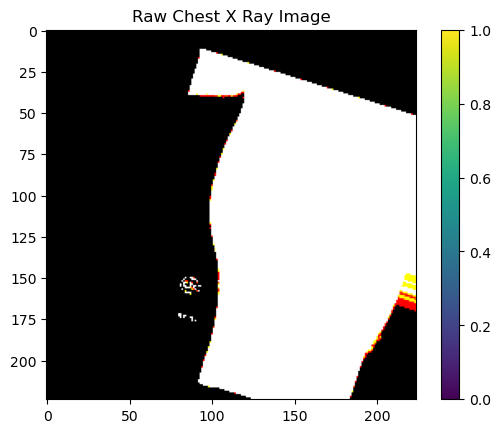

In [17]:
#sns.set_style('white')
generated_image, label = val_data.__getitem__(23)
plt.imshow(generated_image[0])

plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [18]:
generated_image.shape

(1, 224, 224, 3)

In [19]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, softmax, sigmoid, swish
from tensorflow.keras.optimizers import RMSprop 

In [20]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 256x256 with 3 bytes color

    # The first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The fifth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(256, activation='relu'),
    
    # add a dropout layer to prevent overfitting
    tf.keras.layers.Dropout(0.4),

    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(256, activation='relu'),
    
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(1, activation='sigmoid')
])

2022-11-28 09:18:17.572381: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 09:18:17.572726: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0

In [10]:
model.compile(loss='binary_crossentropy', optimizer= RMSprop(learning_rate=0.001), metrics=['acc'])

In [11]:
n_epochs = 20
batch_size = 64

In [12]:
total_sample=train_data.n

In [13]:
history = model.fit( train_data, validation_data= val_data, steps_per_epoch=int(total_sample/batch_size), epochs=n_epochs, verbose=1)

2022-11-17 08:40:31.638030: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-17 08:40:31.638584: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3491795000 Hz


Epoch 1/20


2022-11-17 08:40:32.659634: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-17 08:40:40.254434: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-11-17 08:47:50.746346: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-11-17 08:47:50.808681: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


40/40 [==============================] - 872s 11s/step - loss: 0.6887 - acc: 0.7332 - val_loss: 0.6791 - val_acc: 0.7989
Epoch 2/20
40/40 [==============================] - 402s 10s/step - loss: 0.6764 - acc: 0.7982 - val_loss: 0.6681 - val_acc: 0.7989
Epoch 3/20
40/40 [==============================] - 403s 10s/step - loss: 0.6651 - acc: 0.8027 - val_loss: 0.6575 - val_acc: 0.7989
Epoch 4/20
40/40 [==============================] - 403s 10s/step - loss: 0.6548 - acc: 0.7997 - val_loss: 0.6472 - val_acc: 0.7989
Epoch 5/20
40/40 [==============================] - 403s 10s/step - loss: 0.6441 - acc: 0.8020 - val_loss: 0.6375 - val_acc: 0.7989
Epoch 6/20
40/40 [==============================] - 403s 10s/step - loss: 0.6351 - acc: 0.7986 - val_loss: 0.6280 - val_acc: 0.7989
Epoch 7/20
40/40 [==============================] - 403s 10s/step - loss: 0.6212 - acc: 0.8172 - val_loss: 0.6189 - val_acc: 0.7989
Epoch 8/20
40/40 [==============================] - 408s 10s/step - loss: 0.6127 - acc:

In [14]:
model.evaluate_generator(test_data)

/home/chash345/.conda/envs/research/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.5343754291534424, 0.7997685074806213]

So we have AFF accuracy of 54% and control accuracy of 80%

### Using transfer learning

In [11]:
pre_trained_model = ResNet50(input_shape=(224,224,3),
                                include_top=False,
                                weights="imagenet")

# Some weights in later layers are unfreezed
for layer in pre_trained_model.layers[:-5]:
    layer.trainable=False

In [17]:
pre_trained_model = ResNet50(input_shape=(224,224,3),
                                include_top=False,
                                weights="imagenet")

# Some weights in later layers are unfreezed
for layer in pre_trained_model.layers[:-5]:
    layer.trainable=False

tf.random.set_seed(21)

model = tf.keras.models.Sequential([
    pre_trained_model,
    GlobalAveragePooling2D(),    
    Dense(512,activation="swish"),
    Dropout(0.5),
    Dense(256,activation="swish"),
    Dropout(0.5),  
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [18]:
history = model.fit(
    train_data,
    steps_per_epoch=40,
    epochs=2,
    validation_data=val_data,  
)

Epoch 1/2
40/40 [==============================] - 674s 17s/step - loss: 0.6869 - accuracy: 0.7224 - val_loss: 0.6696 - val_accuracy: 0.7989
Epoch 2/2
40/40 [==============================] - 430s 11s/step - loss: 0.6584 - accuracy: 0.8466 - val_loss: 0.6429 - val_accuracy: 0.7989


In [19]:
model.evaluate(test_data)

14/14 [==============================] - 197s 15s/step - loss: 0.6428 - accuracy: 0.7998


[0.6427768468856812, 0.7997685074806213]

Accuracy jumped 10% for aff class. Need to try more!